task 1

In [32]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from array import array
import datetime
from bs4 import XMLParsedAsHTMLWarning
import warnings

warnings.filterwarnings("ignore", category=XMLParsedAsHTMLWarning)

url = "https://news.google.com/rss/search?q=NVIDIA+stock" 

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36",
    "Accept-Language": "en-US,en;q=0.9",
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8",
    "Referer": "https://news.google.com/rss/search?q=NVIDIA+stock",
    "Connection": "keep-alive",
}

try:
    session = requests.Session()
    session.headers.update(headers)
    # hit homepage first to get cookies/redirects
    session.get("https://news.google.com/rss/search?q=NVIDIA+stock", timeout=10)
    response = session.get(url, timeout=10, allow_redirects=True)
    # debug info if still failing
    if response.status_code == 404:
        print("Got 404 for:", response.url)
        print("Response snippet:", response.text[:500])
        exit()
    response.raise_for_status()
except requests.exceptions.HTTPError:
    print("Request blocked with status code:", response.status_code, "url:", response.url)
    exit()
except Exception as e:
    print("Request error:", e)
    exit()

soup = BeautifulSoup(response.text, "xml")

headlines = []
sources = []
pubdates = []

articles = soup.find_all("item")  # Adjusted class name for Yahoo Finance headlines

for article in articles:
    h = article.find("title")
    headline = h.text.strip() if h else None

    source_tag = article.find("source")
    source = source_tag.text.strip() if source_tag else "Yahoo Finance"

    date_tag = article.find("pubDate")
    pubdate = date_tag.text.strip()[5:17]

    if headline:
        headlines.append(headline)
        sources.append(source)
        pubdates.append(pubdate)

data = {
    "source": sources,
    "headline": headlines,
    "pubdate": pubdates
}

df = pd.DataFrame(data)

df.to_csv("news_raw.csv", index=False)

print("News successfully saved to news_raw.csv")

News successfully saved to news_raw.csv


Task 2: XML Structure Understanding

1.) the tag used to get the article is h3

2.) Each item corresponds to one news article, blog post, update, or announcement

3.) Written in XML with strict, predictable tags.

Uses predefined elements like channel, item, title, link, pubDate.

In [33]:
import pandas as pd
import numpy as np

df = pd.read_csv("news_raw.csv")

df["pubdate"] = pd.to_datetime(df["pubdate"], utc=True).dt.date

df["headline_length"] = df["headline"].astype(str).apply(len)

df.to_csv("news_cleaned.csv", index=False)

print("Cleaned news data saved to news_cleaned.csv")


Cleaned news data saved to news_cleaned.csv


Task 4

In [34]:
import yfinance as yf
import pandas as pd

ticker = "NVDA"

stock = yf.download(ticker, period="10d")

stock_data = stock[["Open", "High", "Low", "Close", "Volume"]]

stock_data.columns = stock_data.columns.get_level_values(0)

stock_data = stock_data.reset_index()

stock_data.to_csv("stock_data.csv", index=False)

print("Stock price data saved to stock_data.csv")



[*********************100%***********************]  1 of 1 completed

Stock price data saved to stock_data.csv


Task 5


Which dates in your news data are non-trading days?
20-12-25,21-12-25,27-12-25,28-12-2025

Why does the stock market not trade on those days?
becuase it was a weekend and the stock market is off on weekends

How many news articles fall on non-trading days?
10 news article were uploaded on NVDA

In [35]:
news_df = pd.read_csv("news_cleaned.csv")
stock_df = pd.read_csv("stock_data.csv")

news_df["pubdate"] = pd.to_datetime(news_df["pubdate"])
stock_df["Date"] = pd.to_datetime(stock_df["Date"])

merged_df = pd.merge(
    news_df,
    stock_df,
    left_on="pubdate",
    right_on="Date",
    how="left"
)

merged_df["is_trading_day"] = merged_df["Open"].notna()
merged_df.to_csv("merged_midterm_data.csv", index=False)


Task 7

News volume per day:
pubdate
2026-01-11     1
2026-01-14     1
2026-01-20     2
2026-01-21     1
2026-01-22     5
2026-01-23    19
2026-01-24     3
2026-01-25     9
2026-01-26    59
dtype: int64


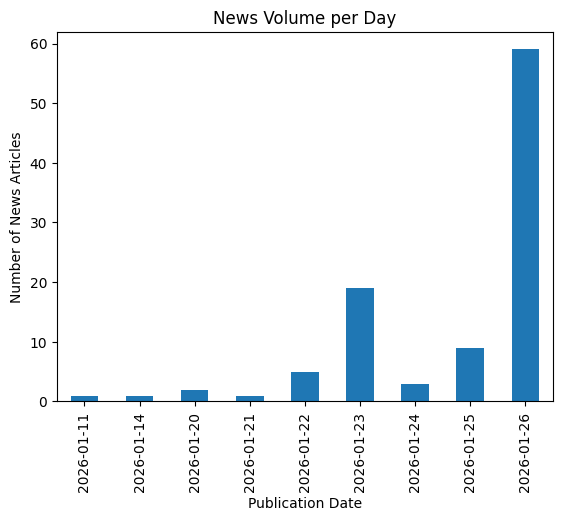

News distribution across sources:
source
Yahoo Finance                      15
The Motley Fool                    13
Investor's Business Daily           7
Barron's                            7
TechStock²                          7
MSN                                 5
Investing.com                       5
CNBC                                3
Nasdaq                              3
TipRanks                            3
Forbes                              3
Investing.com India                 3
Intellectia AI                      2
MarketWatch                         2
The Economic Times                  1
Mint                                1
CoinDesk                            1
Business Insider                    1
Investopedia                        1
CoreWeave                           1
Schaeffer's Investment Research     1
oodaloop.com                        1
Trefis                              1
Traders Union                       1
Fast Company                        1
Investing

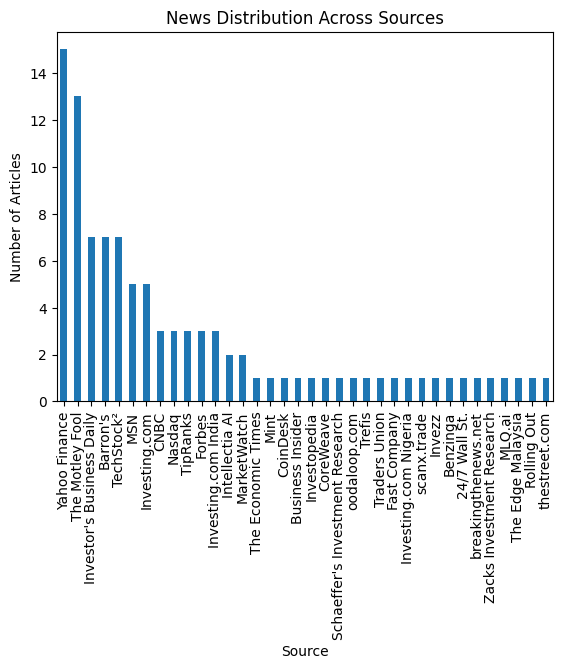

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("news_cleaned.csv")

news_per_day = df.groupby("pubdate").size()

print("News volume per day:")
print(news_per_day)

news_per_day.plot(kind="bar", title="News Volume per Day")
plt.xlabel("Publication Date")
plt.ylabel("Number of News Articles")
plt.show()

news_by_source = df["source"].value_counts()

print("News distribution across sources:")
print(news_by_source)

news_by_source.plot(kind="bar", title="News Distribution Across Sources")
plt.xlabel("Source")
plt.ylabel("Number of Articles")
plt.show()

Sentiment Analysis

In [37]:
import pandas as pd
from transformers import pipeline

sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="ProsusAI/finbert"
)

df = pd.read_csv("merged_midterm_data.csv")

HEADLINE_COLUMN = "headline"
headlines = df[HEADLINE_COLUMN].astype(str).tolist()

results = sentiment_pipeline(headlines)

df["sentiment"] = [r["label"].lower() for r in results]
df["sentiment_confidence"] = [r["score"] for r in results]

df.to_csv("news_with_sentiment.csv", index=False)

print("Sentiment analysis completed. Saved to news_with_sentiment.csv")

Device set to use cpu


Sentiment analysis completed. Saved to news_with_sentiment.csv


Model Training

In [38]:
import pandas as pd

df = pd.read_csv("news_with_sentiment.csv")

df["pubdate"] = pd.to_datetime(df["pubdate"])
df = df.sort_values("pubdate")

df["next_close"] = df["Close"].shift(-1)
df["return_1d"] = (df["next_close"] - df["Close"]) / df["Close"]
df["target"] = (df["return_1d"] > 0).astype(int)

sentiment_map = {
    "positive": 1,
    "neutral": 0,
    "negative": -1
}

df["sentiment_score"] = (
    df["sentiment"].astype(str).str.lower().map(sentiment_map)
    * df["sentiment_confidence"]
)

df = df.dropna(subset=["target", "sentiment_score"])

df.to_csv("news_with_sentiment_final.csv", index=False)

print("✅ Data preparation complete")

✅ Data preparation complete


In [39]:

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

df = pd.read_csv("news_with_sentiment.csv")

df["pubdate"] = pd.to_datetime(df["pubdate"])
df = df.sort_values("pubdate").reset_index(drop=True)

sentiment_map = {"positive": 1, "neutral": 0, "negative": -1}

df["sentiment_score"] = (
    df["sentiment"].astype(str).str.lower().map(sentiment_map)
    * df["sentiment_confidence"]
)

df["next_close"] = df["Close"].shift(-1)
df["return_1d"] = (df["next_close"] - df["Close"]) / df["Close"]

df["target"] = (df["return_1d"] > 0.003).astype(int)

features = [
    "sentiment_score",
    "headline_length",
    "Open",
    "Close",
    "Volume",
    "target"
]

df = df.dropna(subset=features).reset_index(drop=True)

print("\nTarget distribution:")
print(df["target"].value_counts(normalize=True))

df["target"].value_counts(normalize=True).reset_index() \
    .rename(columns={"index": "target", "target": "proportion"}) \
    .to_csv("target_distribution.csv", index=False)

X = df[[
    "sentiment_score",
    "headline_length",
    "Open",
    "Close",
    "Volume"
]]
y = df["target"]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

THRESHOLD = 0.2

metrics = []
prediction_rows = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = RandomForestClassifier(
        n_estimators=300,
        max_depth=6,
        class_weight="balanced",
        random_state=42
    )

    model.fit(X_train, y_train)

    probs = model.predict_proba(X_test)[:, 1]
    preds = (probs > THRESHOLD).astype(int)

    metrics.append({
        "fold": fold,
        "accuracy": accuracy_score(y_test, preds),
        "precision": precision_score(y_test, preds, zero_division=0),
        "recall": recall_score(y_test, preds, zero_division=0),
        "f1": f1_score(y_test, preds, zero_division=0),
        "roc_auc": roc_auc_score(y_test, probs)
    })

    fold_df = df.iloc[test_idx].copy()
    fold_df["predicted_probability"] = probs
    fold_df["predicted_class"] = preds
    fold_df["actual_target"] = y_test.values
    fold_df["correct"] = (preds == y_test.values).astype(int)
    fold_df["fold"] = fold

    prediction_rows.append(
        fold_df[[
            "pubdate",
            "sentiment_score",
            "predicted_probability",
            "predicted_class",
            "actual_target",
            "correct",
            "fold"
        ]]
    )

metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv("fold_wise_results.csv", index=False)

avg_metrics = metrics_df.mean(numeric_only=True).reset_index()
avg_metrics.columns = ["metric", "value"]
avg_metrics.to_csv("model_performance_stats_final.csv", index=False)

prediction_vs_actual = pd.concat(prediction_rows)
prediction_vs_actual.to_csv("prediction_vs_actual.csv", index=False)

print("\n===== FOLD-WISE METRICS =====")
print(metrics_df)

print("\n===== AVERAGE PERFORMANCE =====")
print(avg_metrics)

print("\nFiles saved:")
print("- target_distribution.csv")
print("- fold_wise_results.csv")
print("- model_performance_stats_final.csv")
print("- prediction_vs_actual.csv")



Target distribution:
target
0    0.965517
1    0.034483
Name: proportion, dtype: float64


C:\Users\Hp\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_split.py:813: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Hp\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_ranking.py:442: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\Hp\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_ranking.py:442: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(



===== FOLD-WISE METRICS =====
   fold  accuracy  precision  recall   f1   roc_auc
0     1  0.888889        0.0     0.0  0.0  0.882353
1     2  0.944444        0.0     0.0  0.0  0.941176
2     3  1.000000        0.0     0.0  0.0       NaN
3     4  1.000000        0.0     0.0  0.0       NaN
4     5  0.823529        0.0     0.0  0.0  0.875000

===== AVERAGE PERFORMANCE =====
      metric     value
0       fold  3.000000
1   accuracy  0.931373
2  precision  0.000000
3     recall  0.000000
4         f1  0.000000
5    roc_auc  0.899510

Files saved:
- target_distribution.csv
- fold_wise_results.csv
- model_performance_stats_final.csv
- prediction_vs_actual.csv
